In [1]:
%load_ext autoreload
%autoreload 2

import sys; 
sys.path.insert(0, '../../esinet')
sys.path.insert(0, '../')

import numpy as np
from copy import deepcopy
from scipy.sparse.csgraph import laplacian
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
from invert import focuss
pp = dict(surface='white', hemi='both')

# Get Forward Model

In [2]:
info = get_info(kind='biosemi256')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape
dist = cdist(pos, pos)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished


# Get sample data

In [30]:
# settings = dict(number_of_sources=1, extents=40, duration_of_trial=0.01, target_snr=99999999999)
settings = dict(number_of_sources=3, extents=(25, 40), duration_of_trial=0.01, target_snr=9999999)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()
M = evoked.data

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)

Using control points [1.01441169e-10 3.63379286e-10 9.34185145e-09]


# Minimum Norm Estimate

In [19]:
alpha = 0.001
# if n_chans>n_dipoles:
# D_MNE = np.linalg.inv(leadfield.T @ leadfield + alpha * np.identity(n_dipoles)) @ leadfield.T @ M
# else:
D_MNE = leadfield.T @ np.linalg.inv(leadfield @ leadfield.T + alpha * np.identity(n_chans)) @ M


stc_hat = stc.copy()
stc_hat.data = D_MNE
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'MNE', 'title',
               font_size=14)

Using control points [4.85701273e-10 6.09744437e-10 3.26477596e-09]


# Weighted Minimum Norm Estimate

In [20]:
alpha = 0.001
omega = np.diag(np.linalg.norm(leadfield, axis=0))
I_3 = np.identity(3)
W = omega # np.kron(omega, I_3)

D_WMNE = np.linalg.inv(W.T @ W) @ leadfield.T  @ np.linalg.inv(leadfield @ np.linalg.inv(W.T @ W) @ leadfield.T + alpha * np.identity(n_chans)) @ M

stc_hat = stc.copy()
stc_hat.data = D_WMNE
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'wMNE', 'title',
               font_size=14)

Using control points [2.80720273e-10 3.72595433e-10 2.03990438e-09]


# MNE with FOCUSS (Focal underdetermined system solution)

In [6]:
alpha = 0.001

D_MNE = leadfield.T @ np.linalg.inv(leadfield @ leadfield.T + alpha * np.identity(n_chans)) @ M
D_FOCUSS = focuss(D_MNE, M, leadfield, alpha)



stc_hat = stc.copy()
stc_hat.data = D_FOCUSS
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'MNE FOCUSS', 'title',
            font_size=14)

from scipy.stats import pearsonr
print(np.median([pearsonr(true, predicted)[0] for true, predicted in zip(stc.data.T, stc_hat.data.T)]))
[pearsonr(true, predicted)[0] for true, predicted in zip(stc.data.T, stc_hat.data.T)]

Using control points [1.64117883e-61 1.54014252e-60 6.73830897e-55]
0.2836257641046813


[0.2685517810759354,
 0.2986997471334272,
 0.315739119890639,
 0.22225218545902753,
 0.22806747370075253,
 0.3560821659640143,
 -0.0001520203543446132,
 0.3098643386691541,
 0.3411383767057999,
 0.2630557414104494]

# LORETA

In [21]:
alpha = 0.001
adjacency = mne.spatial_src_adjacency(fwd['src']).toarray()
B = np.diag(np.linalg.norm(leadfield, axis=0))
laplace_operator = laplacian(adjacency)
D_LOR = np.linalg.inv(leadfield.T @ leadfield + alpha * B @ laplace_operator.T @ laplace_operator @ B) @ leadfield.T @ M
# D_LOR = np.linalg.inv(B @ laplace_operator.T @ laplace_operator @ B) @ leadfield.T @ (leadfield @ np.linalg.inv(B @ laplace_operator.T @ laplace_operator @ B) @ leadfield.T + alpha * np.identity(n_chans) ) @ M


stc_hat = stc.copy()
stc_hat.data = D_LOR
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'LORETA', 'title',
            font_size=14)



-- number of adjacent vertices : 1284
Using control points [6.73129592e-10 9.38178191e-10 5.57216022e-09]


# LORETA FOCUSS

In [8]:
alpha = 0.001
adjacency = mne.spatial_src_adjacency(fwd['src'], verbose=0).toarray()
B = np.diag(np.linalg.norm(leadfield, axis=0))
laplace_operator = laplacian(adjacency)
D_LOR = np.linalg.inv(leadfield.T @ leadfield + alpha * B @ laplace_operator.T @ laplace_operator @ B) @ leadfield.T @ M
D_FOCUSS = focuss(D_LOR, M, leadfield, alpha)


stc_hat = stc.copy()
stc_hat.data = D_FOCUSS
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'LORETA FOCUSS', 'title',
            font_size=14)

from scipy.stats import pearsonr
print(np.median([pearsonr(true, predicted)[0] for true, predicted in zip(stc.data.T, stc_hat.data.T)]))
[pearsonr(true, predicted)[0] for true, predicted in zip(stc.data.T, stc_hat.data.T)]

Using control points [8.18126900e-60 5.33884852e-59 2.74830776e-54]
0.36802017580204216


[0.4299586395146592,
 0.37731506760559325,
 0.40206881749917933,
 0.26968784101373877,
 0.31873949483511677,
 0.35721739189234036,
 0.20603070044583105,
 0.4350197583889355,
 0.38490097117140826,
 0.3587252839984911]

# sLORETA

In [22]:
alpha = 0.001
K_MNE = leadfield.T @ np.linalg.inv(leadfield @ leadfield.T + alpha * np.identity(n_chans))
D_MNE = K_MNE @ M
W_diag = 1 / np.diag(K_MNE @ leadfield)

W_slor = np.diag(W_diag)

W_slor = np.sqrt(W_slor)

K_slor = W_slor @ K_MNE
D_SLOR = K_slor @ M
D_SLOR[np.isnan(D_SLOR)] = 0

stc_hat = stc.copy()
stc_hat.data = D_SLOR
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'sLORETA', 'title',
            font_size=14)

Using control points [1.30612080e-09 1.60498484e-09 6.18251116e-09]


C:\Users\Lukas\AppData\Local\Temp/ipykernel_4564/719602940.py:8: RuntimeWarning: invalid value encountered in sqrt
  W_slor = np.sqrt(W_slor)


# sLORETA FOCUSS

In [10]:
alpha = 0.001
K_MNE = leadfield.T @ np.linalg.inv(leadfield @ leadfield.T + alpha * np.identity(n_chans))
D_MNE = K_MNE @ M
W_diag = 1 / np.diag(K_MNE @ leadfield)

W_slor = np.diag(W_diag)

W_slor = np.sqrt(W_slor)

K_slor = W_slor @ K_MNE
D_SLOR = K_slor @ M
D_SLOR[np.isnan(D_SLOR)] = 0

D_SLOR_FOCUSS = focuss(D_SLOR, M, leadfield, alpha)

stc_hat = stc.copy()
stc_hat.data = D_SLOR_FOCUSS
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'sLORETA FOCUSS', 'title',
            font_size=14)

C:\Users\Lukas\AppData\Local\Temp/ipykernel_4564/3213525492.py:8: RuntimeWarning: invalid value encountered in sqrt
  W_slor = np.sqrt(W_slor)


Using control points [9.10673214e-60 5.86881077e-59 8.88874396e-54]


# eLORETA

In [23]:
from invert import calc_eloreta_D
stop_crit = 0.005
alpha = 0.001

D, C = calc_eloreta_D(leadfield, alpha, stop_crit=stop_crit)
K_elor = np.linalg.inv(D) @ leadfield.T @ np.linalg.inv( leadfield @ np.linalg.inv(D) @ leadfield.T + alpha * np.identity(n_chans) )
D_ELOR = K_elor @ M



stc_hat = stc.copy()
stc_hat.data = D_ELOR
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'eLORETA', 'title',
            font_size=14)


Optimizing eLORETA weight matrix W...
	rep 1
averagePercentChange=63.99 %
	rep 2
averagePercentChange=35.95 %
	rep 3
averagePercentChange=17.91 %
	rep 4
averagePercentChange=8.64 %
	rep 5
averagePercentChange=4.15 %
	rep 6
averagePercentChange=2.01 %
	rep 7
averagePercentChange=0.98 %
	rep 8
averagePercentChange=0.48 %
	...converged...
	...done!
Using control points [5.03798676e-10 7.26406270e-10 3.57532898e-09]


# eLORETA FOCUSS

In [12]:
from invert import calc_eloreta_D
stop_crit = 0.005
alpha = 0.001

# D, C = calc_eloreta_D(leadfield, alpha, stop_crit=stop_crit)
# K_elor = np.linalg.inv(D) @ leadfield.T @ np.linalg.inv( leadfield @ np.linalg.inv(D) @ leadfield.T + alpha * np.identity(n_chans) )
# D_ELOR = K_elor @ M
d_ELOR_FOCUSS = focuss(D_ELOR, M, leadfield, alpha)


stc_hat = stc.copy()
stc_hat.data = D_ELOR
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'eLORETA FOCUSS', 'title',
            font_size=14)


Using control points [4.96301314e-10 7.20781971e-10 3.98667599e-09]


# LAURA

In [33]:
drop_off = 2
d = cdist(pos, pos)
# Get the adjacency matrix of the source spaces
adj = mne.spatial_src_adjacency(fwd["src"], verbose=0).toarray()
for i in range(d.shape[0]):
    # find dipoles that are no neighbor to dipole i
    non_neighbors = np.where(~adj.astype(bool)[i, :])[0]
    # append dipole itself
    non_neighbors = np.append(non_neighbors, i)
    # set non-neighbors to zero
    d[i, non_neighbors] = 0
A = -d**-drop_off
A[np.isinf(A)] = 0
W = np.identity(A.shape[0])
M_j = W @ A

# Source Space metric
W_j = np.linalg.inv(M_j.T @ M_j)
W_j_inv = np.linalg.inv(W_j)

W_d = np.linalg.inv(np.identity(n_chans))
noise_term = (alpha**2) * np.linalg.inv(W_d)
G = W_j_inv @ leadfield.T @ np.linalg.inv(leadfield @ W_j_inv @ leadfield.T + noise_term)
D_LAURA = G @ M

stc_hat.data = D_LAURA
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'LAURA', 'title',
            font_size=14)

C:\Users\Lukas\AppData\Local\Temp/ipykernel_4564/2011205979.py:12: RuntimeWarning: divide by zero encountered in power
  A = -d**-drop_off


Using control points [6.13522133e-10 9.09040024e-10 6.38616863e-09]


# VARETA

In [38]:
# 1) J & JVareta given; find A
# 2) A given, find J
# 3) repeat until convergence

2.8284271247461903

In [52]:
(L * np.diag(np.log(np.diagonal(A)))).shape

C:\Users\Lukas\AppData\Local\Temp/ipykernel_4564/809148777.py:1: RuntimeWarning: invalid value encountered in log
  (L * np.diag(np.log(np.diagonal(A)))).shape


(1284, 1284)

In [54]:
np.dot(np.identity(3)*2, np.identity(3)*2)

array([[4., 0., 0.],
       [0., 4., 0.],
       [0., 0., 4.]])

In [69]:
 
# alpha = 0.001
adjacency = mne.spatial_src_adjacency(fwd['src'], verbose=0).toarray()
B = np.diag(np.linalg.norm(leadfield, axis=0))
L = laplacian(adjacency)  # non-singular univariate discrete laplacian -> is that correct?
D_LOR = np.linalg.inv(leadfield.T @ leadfield + alpha * B @ L.T @ L @ B) @ leadfield.T @ M
D_Last = deepcopy(D_LOR)[:, 0][:, np.newaxis]
W = np.diag(np.linalg.norm(leadfield, axis=0))  # WMNE weight matrix (depth weighting)
tau = 1  # controls smoothness
alpha_2 = 1  # controls importance of grid point
# for t in range(M.shape[1]):
t = 0
A = np.identity(n_dipoles)  # in paper: large lambda
    
# for _ in range(10):
term_1 = np.linalg.norm( M[:, t] - leadfield @ D_Last )
term_2 = np.linalg.norm( A@L * W * D_Last )
term_3 = tau**2 * np.linalg.norm( L * np.diag(np.log(np.diagonal(A))) - alpha_2 )

def find_lambda(A, m, leadfield, D_last, L, W, tau, alpha_2):
    term_1 = np.linalg.norm( M[:, t] - leadfield @ D_Last )
    term_2 = np.linalg.norm( A@L * W * D_Last )
    term_3 = tau**2 * np.linalg.norm( L * np.diag(np.log(np.diagonal(A))) - alpha_2 )
    return term_1 + term_2 + term_3

# D_VAR = term_1 + term_2 + term_3



In [ ]:
from scipy.optimize import minimize
def find_lambda(A, m, leadfield, D_last, L, W, tau, alpha_2):
    term_1 = np.linalg.norm( M[:, t] - leadfield @ D_Last )
    term_2 = np.linalg.norm( A@L * W * D_Last )
    term_3 = tau**2 * np.linalg.norm( L * np.diag(np.log(np.diagonal(A))) - alpha_2 )
    return term_1 + term_2 + term_3
find_lambda(A, M[:, t], leadfield, D_Last, L, W, tau, alpha_2)
# minimize(find_lambda, A, M[:, t], leadfield, D_Last, L, W, tau, alpha_2)


# LUCAS

In [34]:
stc_hat.data = np.mean([D_MNE , D_WMNE, D_LOR, D_SLOR, D_ELOR, D_LAURA], axis=0)



brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'LUCAS', 'title',
            font_size=14)

Using control points [1.56799888 1.81482778 5.2855019 ]


# Saved for later

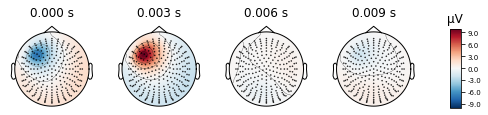

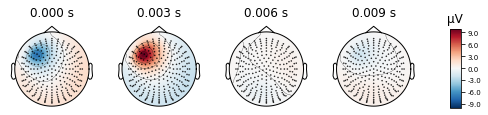

In [13]:
from esinet.util import get_eeg_from_source
evoked_hat = get_eeg_from_source(stc_hat, fwd, info, tmin=stc.tmin)
evoked_hat.plot_topomap()

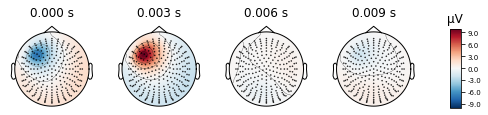

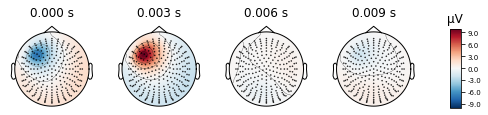

Using control points [2.61259603e-10 1.34102782e-09 4.21372560e-09]
Using control points [4.75824040e-10 6.71989799e-10 4.22817116e-09]
Using control points [7.05457627e-10 1.00623835e-09 3.40595310e-09]
Using control points [7.05457627e-10 1.00623835e-09 3.40595310e-09]
Using control points [7.37586661e-58 5.02752462e-57 2.72782248e-53]
Using control points [8.53104654e-10 1.18058837e-09 3.78896262e-09]


In [14]:
evoked.plot_topomap()